## Thalassemia Classification Pipeline with Bootstrapping and SMOTE
###  Import Required Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load the original and bootstrapped datasets
df_original = pd.read_csv('alpha_combined_cleaned.csv')
df_bootstrapped = pd.read_csv('alpha_thalassemia_gaussian_bootstrapped_dataset.csv')

d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Original Dataset Model Performance
Accuracy: 0.125

Classification Report:
                 precision    recall  f1-score   support

 alpha carrier       0.24      0.22      0.23        37
   alpha trait       0.00      0.00      0.00        11
        normal       0.07      0.07      0.07        14
silent carrier       0.08      0.08      0.08        26

      accuracy                           0.12        88
     macro avg       0.09      0.09      0.09        88
  weighted avg       0.13      0.12      0.13        88



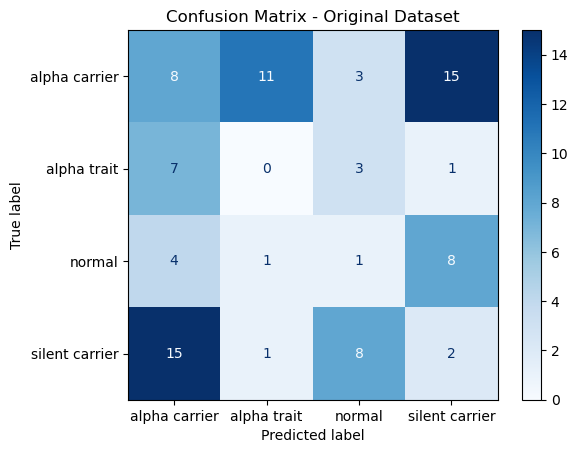

In [4]:
# Encode categorical features
label_encoder = LabelEncoder()
df_original['phenotype_encoded'] = label_encoder.fit_transform(df_original['phenotype'])
df_original['sex_encoded'] = LabelEncoder().fit_transform(df_original['sex'])

# Prepare features and labels
X = df_original[['hb', 'rbc', 'mcv', 'mch', 'hba2', 'sex_encoded']]
y = df_original['phenotype_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Build model
model_original = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_original.fit(X_train, y_train)

# Evaluate model
y_pred = model_original.predict(X_test)
print("Original Dataset Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Original Dataset')
plt.show()

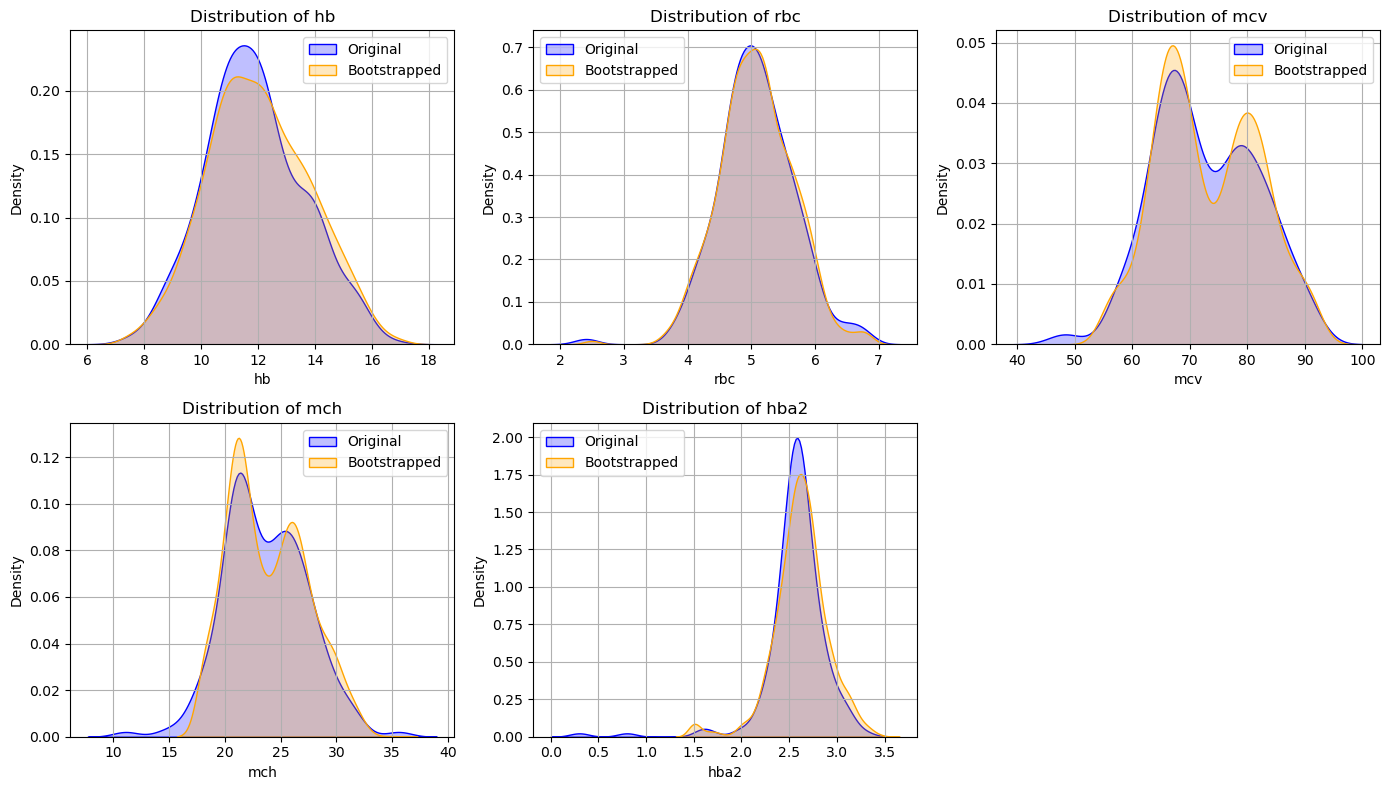

In [5]:
features = ['hb', 'rbc', 'mcv', 'mch', 'hba2']
plt.figure(figsize=(14, 8))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(df_original[feature], label='Original', fill=True, color='blue')
    sns.kdeplot(df_bootstrapped[feature], label='Bootstrapped', fill=True, color='orange')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Bootstrapped Dataset Model Performance
Accuracy: 0.612

Classification Report:
                 precision    recall  f1-score   support

 alpha carrier       0.61      0.56      0.59       175
        normal       0.69      0.85      0.76       225
silent carrier       0.25      0.16      0.20       100

      accuracy                           0.61       500
     macro avg       0.52      0.52      0.52       500
  weighted avg       0.58      0.61      0.59       500



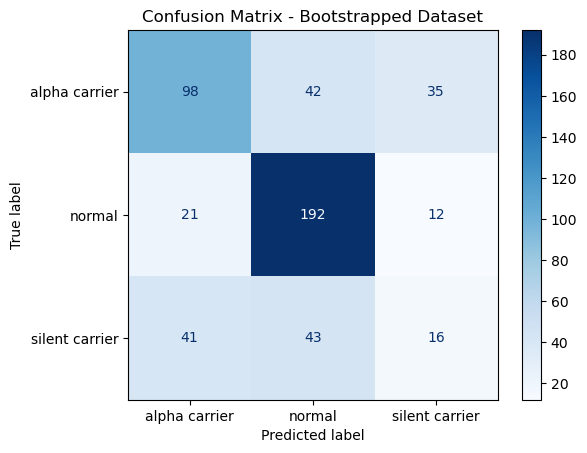

In [13]:
# Encode bootstrapped dataset
label_encoder_boot = LabelEncoder()
df_bootstrapped['phenotype_encoded'] = label_encoder_boot.fit_transform(df_bootstrapped['phenotype'])

# Encode categorical features in bootstrapped dataset
sex_encoder_boot = LabelEncoder()
df_bootstrapped['sex_encoded'] = sex_encoder_boot.fit_transform(df_bootstrapped['sex'])

# Prepare features and labels
X_boot = df_bootstrapped[['hb', 'rbc', 'mcv', 'mch', 'hba2', 'sex_encoded']]
y_boot = df_bootstrapped['phenotype_encoded']

# Train-test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_boot, y_boot, stratify=y_boot, test_size=0.25, random_state=42)

# Build model
model_boot = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_boot.fit(X_train_b, y_train_b)

# Evaluate model
y_pred_b = model_boot.predict(X_test_b)
print("\nBootstrapped Dataset Model Performance")
print("Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_b, target_names=label_encoder_boot.classes_))

# Plot confusion matrix
cm_b = confusion_matrix(y_test_b, y_pred_b)
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=label_encoder_boot.classes_)
disp_b.plot(cmap='Blues')
plt.title('Confusion Matrix - Bootstrapped Dataset')
plt.show()


d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:54:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



SMOTE-Augmented Model Performance
Accuracy: 0.6

Classification Report:
                 precision    recall  f1-score   support

 alpha carrier       0.60      0.50      0.55       175
        normal       0.72      0.78      0.75       225
silent carrier       0.34      0.37      0.35       100

      accuracy                           0.60       500
     macro avg       0.55      0.55      0.55       500
  weighted avg       0.60      0.60      0.60       500



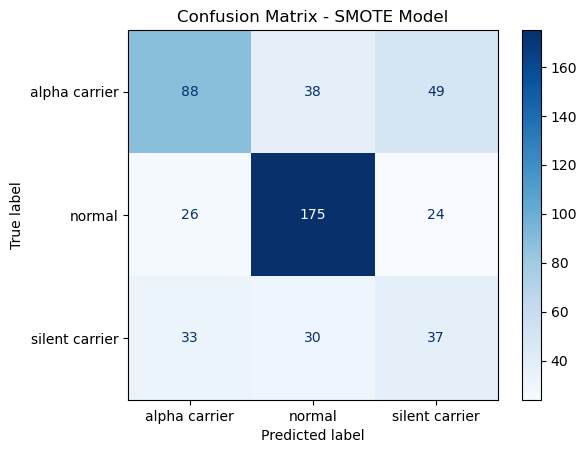

In [14]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_b_imputed = imputer.fit_transform(X_train_b)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_b_imputed, y_train_b)

# Build model with SMOTE data
model_smote = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Evaluate model
y_pred_smote = model_smote.predict(X_test_b)
print("\nSMOTE-Augmented Model Performance")
print("Accuracy:", accuracy_score(y_test_b, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_smote, target_names=label_encoder_boot.classes_))

# Plot confusion matrix
cm_smote = confusion_matrix(y_test_b, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=label_encoder_boot.classes_)
disp_smote.plot(cmap='Blues')
plt.title('Confusion Matrix - SMOTE Model')
plt.show()

In [15]:
print("""
Summary:
- The model on the original dataset had low accuracy due to limited data.
- Bootstrapping improved class balance and led to higher accuracy and better learning.
- SMOTE further improved minority class detection and provided a more balanced classification performance.
""")


Summary:
- The model on the original dataset had low accuracy due to limited data.
- Bootstrapping improved class balance and led to higher accuracy and better learning.
- SMOTE further improved minority class detection and provided a more balanced classification performance.

